In [116]:
pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

  Cloning git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-ec13yhr1
  Running command git clone -q git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-ec13yhr1


In [117]:
#@title
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

In [118]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [119]:
import pandas as pd
import os
subtitle = "/content/drive/My Drive/subtitle/" 

# read file line by line
def load_corpus(url):
  raw_data = []
  index = []
  for fi in os.listdir(subtitle):
    index.append(fi)
    txt = []
    file = open(os.path.join(url, fi), "r",encoding="utf-8", errors='ignore')
    lines = file.readlines()
    file.close()
    for line in lines[24:]:
      if not line.startswith('00') and line!='\n':
        word=line
        if '\n' in word:
          word = word.replace('\n', '')
        if '<i>' in word:
          word = word.replace('<i>','')
        if '</i>' in word:
          word = word.replace('</i>', '')
        if '{\\an8}' in word:
          word = word.replace('{\\an8}', '')
        if not word.isdecimal():
          if word.startswith('-'):
            txt.append(word[1:])
          else:
            txt.append(word)
    raw_data.append(' '.join(txt))
  return raw_data, index

raw_hw, index_hw = load_corpus(subtitle)
raw_hw.pop(-1)
index_hw.pop(-1)
for i, title in enumerate(index_hw):
  index_hw[i]='hw_'+title

subtitle_kr = '/content/drive/My Drive/subtitle_kr/'
raw_kr, index_kr = load_corpus(subtitle_kr)
raw_kr.pop(-1)
index_kr.pop(-1)
for i, title in enumerate(index_kr):
  index_kr[i]='kr_'+title

index_hw.extend(index_kr)
raw_hw.extend(raw_kr)

season = []
for i in index_hw:
  if i.startswith('hw'):
    season.append('Aloha State')
  else:
    season.append('Karuizawa')

df = pd.DataFrame({'raw_data':raw_hw, 'category' : season}, index = index_hw)

In [120]:
df

,raw_data,category
hw_episode1,"Tonight, we start a new season in Hawaii. Terr...",Aloha State
hw_episode2,Terrace House: Aloha State has begun. Yes! The...,Aloha State
hw_episode3,I'm certain you've noticed that Torichan is no...,Aloha State
hw_episode4,Torichan is at a very important job once again...,Aloha State
hw_episode5,"Last time, there was the surfing issue... Laur...",Aloha State
...,...,...
kr_episode32,Let's see. A lot happened last week. Let's sta...,Karuizawa
kr_episode33,Let's see. Last week... things started out lig...,Karuizawa
kr_episode34,"Let's see. Last week, Shunsuke moved in. He an...",Karuizawa
kr_episode35,"Let's see. Three members left last week. Yes, ...",Karuizawa


In [121]:
th_count_vec = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
th_Vects = th_count_vec.fit_transform(df['raw_data'])
th_trans = sklearn.feature_extraction.text.TfidfTransformer().fit(th_Vects)
#train
thTF = th_trans.transform(th_Vects)
print(thTF.shape)

(72, 7936)


In [122]:
#reduce the volume of target words
thTFvectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.31, max_features=2000, min_df=1, stop_words='english', norm='l2')
thTFVects = thTFvectorizer.fit_transform(df['raw_data'])


In [123]:
try:
    print(thTFvectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(thTFvectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['aloha', 'state', 'trip', 'confidence', 'yamachan', 'lost', 'ala', 'moana', 'center', 'yu'] ...


In [124]:
num_cate = len(set(df['category']))
k_m = sklearn.cluster.KMeans(n_clusters = num_cate, init = 'k-means++')
k_m.fit(thTFVects)


KMeans(n_clusters=2)

In [125]:
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(df['category'], k_m.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(df['category'], k_m.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(df['category'], k_m.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(df['category'], k_m.labels_)))

For our clusters:
Homogeneity: 0.248
Completeness: 0.336
V-measure: 0.286
Adjusted Rand Score: 0.166


In [126]:
df['km_pred']= k_m.labels_

In [127]:
terms = thTFvectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = k_m.cluster_centers_.argsort()[:, ::-1]
for i in range(num_cate):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 ami
 cheri
 yusuke
 niki
 yuudai
 chikako
 naomi
 wez
 18
 soba


Cluster 1:
 noah
 yui
 aya
 mayu
 konnyaku
 shunsuke
 skateboarding
 waterfall
 riding
 horseback




In [128]:
PCA = sklearn.decomposition.PCA
th_pca = PCA(n_components=2).fit(thTFVects.toarray())
reduced_th = th_pca.transform(thTFVects.toarray())

components = th_pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

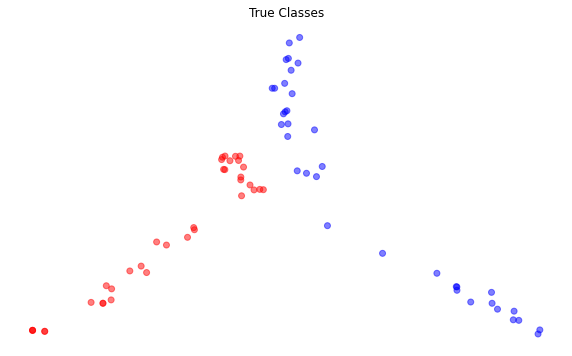

In [129]:


color = {'Aloha State': 'red', 'Karuizawa': 'blue'}
th_colar = [color[c] for c in df['category']]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_th[:, 0], reduced_th[:, 1], color = th_colar, alpha = 0.5, label = th_colar)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

In [130]:
#@title  { form-width: "300px" }
#@title
name_cate = ['Aloha State', 'Karuizawa']
colors_p = [color[name_cate[l]] for l in k_m.labels_]

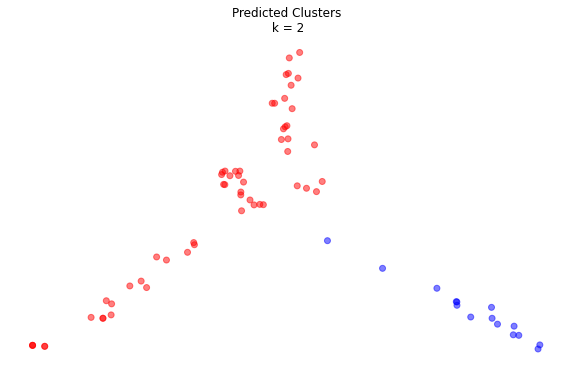

In [131]:
#@title  { form-width: "100px" }
#@title  { form-width: "500px" }
#@title
reduced_data = reduced_th
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_th[:, 0], reduced_th[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 2')
plt.show()

In [132]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = th_pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


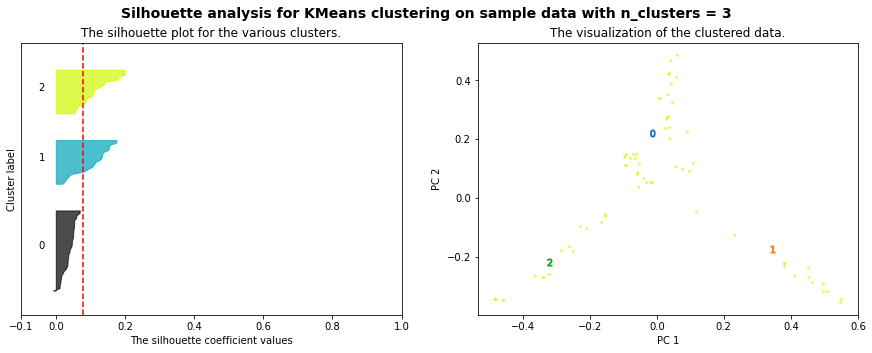

For n_clusters = 3, The average silhouette_score is : 0.077


In [133]:
X = thTFVects.toarray()
plotSilhouette(3,X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


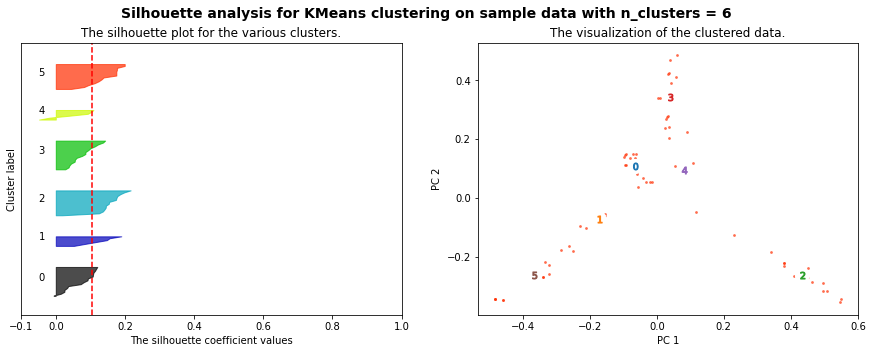

For n_clusters = 6, The average silhouette_score is : 0.105


In [134]:
plotSilhouette(6,X)

**Based on the analysis above, the most appropriate cluster number would be 3. Since I extracted two kinds of text data from the same reality show, terras house, of different seasons, 3 might sound weird. Two seasons should be distinct in a sense that one, season of 'Aloha State', should have more cultural diversity and the other, season of 'Karuizawa' has more cultural homogeneity. However, the difference does not appeat to be explicit.**

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<font color="red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

In [135]:
th_coocmat = thTFVects * thTFVects.T

th_coocmat.setdiag(0)

#th_coocmat = 1 - sklearn.metrics.pairwise.cosine_similarity(thTFVects)

In [136]:
selectIndices = []
indexToCat = []
for c in set(df['category']):
    selectIndices += list(df[df['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [137]:
type(th_coocmat)

scipy.sparse.csr.csr_matrix

In [138]:
subCoocMat = th_coocmat

linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[12.        , 15.        ,  0.31898668,  2.        ],
       [11.        , 13.        ,  0.36067808,  2.        ],
       [14.        , 72.        ,  0.38044424,  3.        ],
       [47.        , 49.        ,  0.40273719,  2.        ],
       [41.        , 43.        ,  0.41568424,  2.        ],
       [51.        , 75.        ,  0.43837836,  3.        ],
       [ 0.        ,  8.        ,  0.4498848 ,  2.        ],
       [10.        , 74.        ,  0.45259605,  4.        ],
       [46.        , 50.        ,  0.46133837,  2.        ],
       [45.        , 77.        ,  0.46308034,  4.        ]])

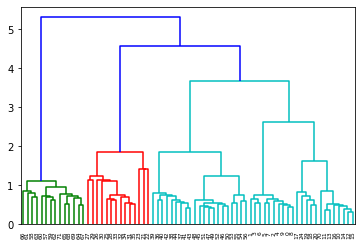

In [139]:

dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

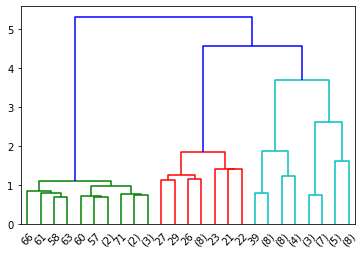

In [140]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

In [141]:
#with fcluster method
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 3, 'maxclust')
linkage_matrix_full = scipy.cluster.hierarchy.ward(th_coocmat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
def print_results(result):
  print("For our complete clusters:")
  print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(df['category'], result)))
  print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(df['category'], result)))
  print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(df['category'], result)))
  print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(df['category'], result)))

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


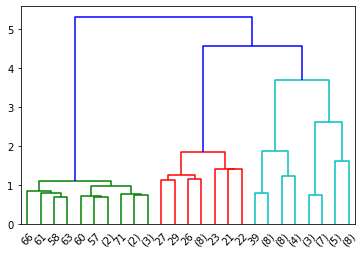

In [142]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix_full, p=4, truncate_mode='level', get_leaves=True)

In [143]:
#With ncluster method
print_results(hierarchicalClusters_full)

For our complete clusters:
Homogeneity: 0.918
Completeness: 0.467
V-measure: 0.619
Adjusted Rand Score: 0.481


In [144]:
#with simple decision tree
print_results(hierarchicalClusters)

For our complete clusters:
Homogeneity: 0.389
Completeness: 0.287
V-measure: 0.331
Adjusted Rand Score: 0.138


In [145]:
df['wald_pred']= hierarchicalClusters_full

**Comparing between ones with simple decision tree method and ncluster method, we can see that n cluster method is more capable of capturing homogeneity and completeness of the documents. Also, decision methods supports that the number of the cluster on our datasets is 3.**

**In a comparison with k-mean method, decision tree methods are doing the way better job. Reasons for this might be nature of hierarchical clustering. The method works better in clustering text data, but it is not working well with huge amount of datasets. Then, since my text data is not as big as 1 billion sentences, it worked pretty well for my analysis.**

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<font color="red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</font> 

In [146]:
#@title
from gensim.models import HdpModel

In [147]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

In [148]:
df['tokenized_text'] = df['raw_data'].apply(lambda x: lucem_illud.word_tokenize(x))
df['normalized_tokens'] = df['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))
df['reduced_tokens'] = df['normalized_tokens'].apply(lambda x: dropMissing(x, thTFvectorizer.vocabulary_.keys()))

In [149]:
dictionary = gensim.corpora.Dictionary(df['reduced_tokens'])
corpus = [dictionary.doc2bow(text) for text in df['reduced_tokens']]
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [150]:
df['name'] = index_hw

In [155]:
sen1Bow = dictionary.doc2bow(df['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
ldaDF = pandas.DataFrame({
        'name' : df['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in df['reduced_tokens']]
    })

In [156]:
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
hw_episode1,hw_episode1,"[(3, 0.0718284), (8, 0.92325205)]",0.000000,0.000000,0.0,0.071828,0.000000,0.000000,0.000000,0.0,0.923252,0.0
hw_episode2,hw_episode2,"[(0, 0.9947514)]",0.994751,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
hw_episode3,hw_episode3,"[(0, 0.46686482), (8, 0.52755594)]",0.466865,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.527556,0.0
hw_episode4,hw_episode4,"[(0, 0.036742955), (3, 0.20905058), (5, 0.6255...",0.036743,0.000000,0.0,0.209051,0.000000,0.625524,0.000000,0.0,0.123835,0.0
hw_episode5,hw_episode5,"[(3, 0.119143486), (5, 0.87628675)]",0.000000,0.000000,0.0,0.119143,0.000000,0.876287,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
kr_episode32,kr_episode32,"[(0, 0.4051316), (4, 0.014466815), (6, 0.57600...",0.405132,0.000000,0.0,0.000000,0.014467,0.000000,0.576001,0.0,0.000000,0.0
kr_episode33,kr_episode33,"[(0, 0.9937399)]",0.993740,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
kr_episode34,kr_episode34,"[(0, 0.94488037), (4, 0.050087128)]",0.944880,0.000000,0.0,0.000000,0.050087,0.000000,0.000000,0.0,0.000000,0.0
kr_episode35,kr_episode35,"[(1, 0.86593664), (5, 0.12767567)]",0.000000,0.865937,0.0,0.000000,0.000000,0.127676,0.000000,0.0,0.000000,0.0


In [157]:
def plot_bar(ldaDFVis,ldaDFVisNames):
  N = 10
  ind = np.arange(N)
  K = senlda.num_topics  # N documents, K topics
  ind = np.arange(N)  # the x-axis locations for the novels
  width = 0.5  # the width of the bars
  plots = []
  height_cumulative = np.zeros(N)

  for k in range(K):
      color = plt.cm.coolwarm(k/K, 1)
      if k == 0:
          p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
      else:
          p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
      height_cumulative += ldaDFVis[:, k]
      plots.append(p)
      

  plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
  plt.ylabel('Topics')

  plt.title('Topics in Press Releases')
  plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

  plt.yticks(np.arange(0, 1, 10))
  topic_labels = ['Topic #{}'.format(k) for k in range(K)]
  plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

  plt.show()

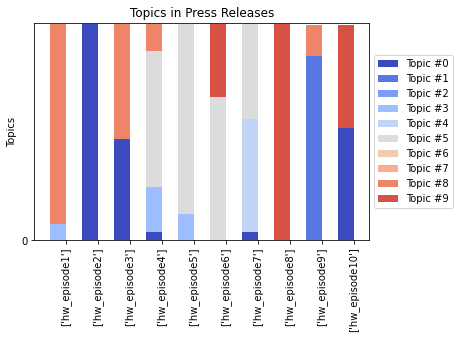

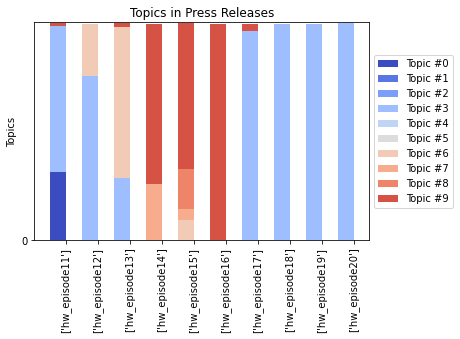

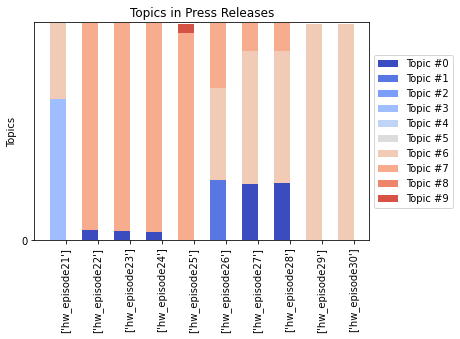

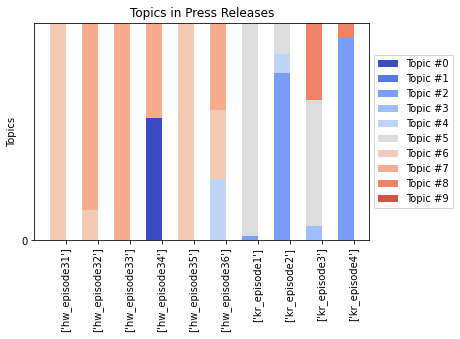

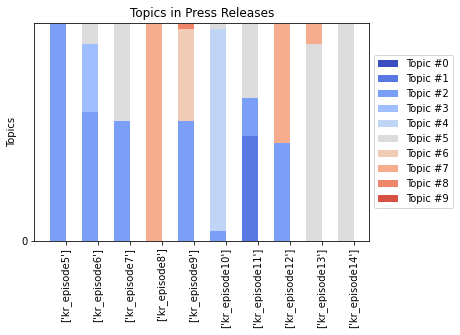

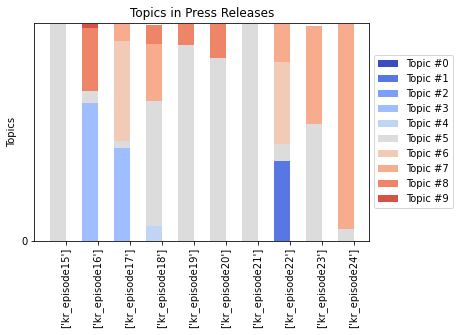

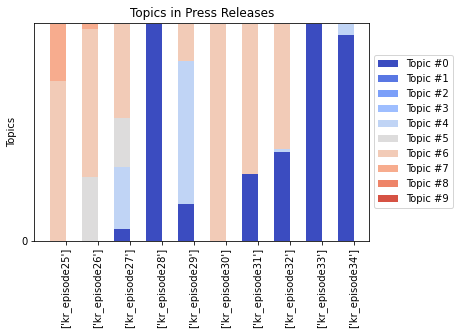

In [158]:
for i in range(7):
  ldaDFV = ldaDF[i*10:(i+1)*10][['topic_%d' %x for x in range(10)]]
  ldaDFVisN = ldaDF[i*10:(i+1)*10][['name']]
  ldaDFVis = ldaDFV.to_numpy()
  ldaDFVisNames = ldaDFVisN.to_numpy()
  plot_bar(ldaDFVis, ldaDFVisNames)

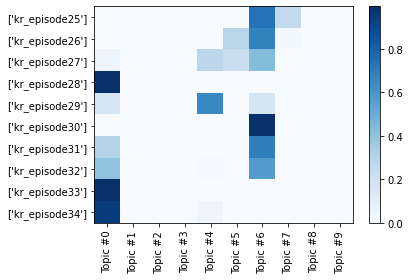

In [159]:
topic_labels = ['Topic #{}'.format(k) for k in range(senlda.num_topics)]
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [160]:
senlda.show_topic(1)

[('ami', 0.010005114),
 ('yui', 0.007837199),
 ('bite', 0.0069109797),
 ('naomi', 0.0065224157),
 ('yusuke', 0.00599198),
 ('cook', 0.0052124336),
 ('cheer', 0.0051926924),
 ('yuudai', 0.0050025973),
 ('noah', 0.004790229),
 ('mayu', 0.00453131)]

In [161]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,noah,ami,ami,niki,noah,ami,noah,yui,ami,niki
1,yui,yui,yuudai,ami,yui,bite,yui,cheri,yuudai,wave
2,cheri,bite,cook,yusuke,bite,yui,chikako,mayu,yusuke,cook
3,yusuke,naomi,yui,drive,ami,yuudai,cheri,noah,team,ami
4,aya,yusuke,noah,bite,yuudai,noah,bite,ami,cook,naomi
5,bite,cook,mayu,cheer,yusuke,yusuke,mayu,niki,soba,yusuke
6,cheer,cheer,bite,soba,cheer,mayu,forget,wez,bite,cheri
7,naomi,yuudai,drive,yuudai,niki,word,aya,chikako,cheer,goal
8,chikako,noah,cheri,begin,aya,team,banana,ex,naomi,bite
9,wez,mayu,kid,worth,surprise,hockey,cheer,bite,goal,cheer


<Figure size 432x288 with 0 Axes>

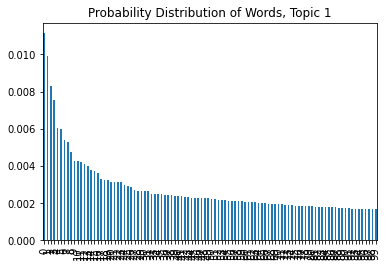

In [162]:
topic1_df = pandas.DataFrame(senlda.show_topic(9, topn=100))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

In [163]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

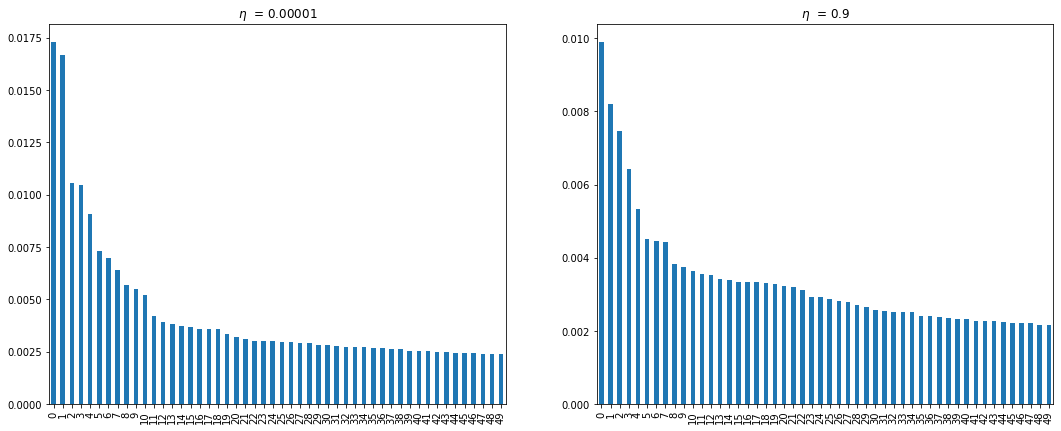

In [164]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

**Document-topic leading reveals that, for both seasons, topics of documents moves topic 9 to topic 1 as episode goes on. Then, topic-word leading shows many corpura of names of the people in the show. Since people frequently move out and in within one season, names that appear in the show slightly vary across episodes. Controlling the value of 𝜂 clearly affects the sparcity of word distribution in a certain topic such as topic 1 in the graphs**



## <font color="red">*Exercise 4*</font>

<font color="red">Construct cells immediately below this that use dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

In [165]:
#@title
from gensim.matutils import kullback_leibler

In [166]:
#@title
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [167]:
#@title
import collections

In [168]:
#@title
def choose_n(corpus, time_slices, nums=1):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

In [177]:
#@title
def split_up(document, doc_size=1000):
    new_docs = [document[i:i + doc_size] for i in range(0, len(document), doc_size)]
    return(new_docs, len(new_docs))

In [170]:
#@title
from gensim.models import ldaseqmodel

In [171]:
nested = list(df['tokenized_text'])
dool=[element for sublist in nested for element in sublist]
' '.join(dool[0:1500])

"Tonight we start a new season in Hawaii Terrace House Aloha State Hawaii was fun was n't it So much fun We went too It was the most fun I had on a work trip It was really fun I can say it with confidence that I had fun Hawaii Hawaii It was nice was n't it It was But on our last day Yamachan That 's right He got lost at Ala Moana Center It was like give us a break Seriously That was the only hiccup Yu told me that I was definitely the least eligible bachelor You 're the number one bachelor right now Yes he 's number one right now Tokui is so sweet Every day he 'd find out what 's the best burger place for us to go to Yes thank you It 's easy with the Internet Yes the difference was astounding Torichan In Hawaii I realized how different men can be from one another I got in trouble at customs That 's right And one time I got lost You got plastered Yes very You could n't check in You opened your luggage in the lobby You opened all your luggage in the lobby thinking it was your room Did yo

In [175]:
df['episode'] = df['name'].apply(lambda x: int(x[10:]))

In [192]:
sliced_corpus = [[],[],[],[]]
final_corp = []
for text, episode in zip(df['normalized_tokens'], df['episode']):
  if episode < 9:
    sliced_corpus[0].extend(text)
  if 9 <= episode and episode < 18:
    sliced_corpus[1].extend(text)
  if 18 <= episode and episode < 27:
    sliced_corpus[2].extend(text)
  if 27 <= episode:
    sliced_corpus[3].extend(text)

time_slice = [0,0,0,0]
for i, lst in enumerate(sliced_corpus):
  splited, num = split_up(lst)
  for doc in splited:
    final_corp.append(doc)
  time_slice[i] += num

  if np.sum(time_slice) != len(final_corp):
    print(np.sum(time_slice), len(final_corp))
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [193]:
dic = gensim.corpora.Dictionary(final_corp)
corpus =  [dictionary.doc2bow(text) for text in final_corp]
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [195]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=time_slice, num_topics=3)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldaseqmodel.py:290: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [196]:
ldaseq.print_topics(time=0)[1]

[('ami', 0.018491444736025788),
 ('yui', 0.013815977731911273),
 ('noah', 0.013612917979848038),
 ('yuudai', 0.009835294693519242),
 ('bite', 0.009176109183666662),
 ('mayu', 0.009081036321741755),
 ('cook', 0.007384267705890817),
 ('team', 0.006221758770783446),
 ('soba', 0.005250676551093932),
 ('hockey', 0.0051567197646410785),
 ('cheer', 0.004938150604675681),
 ('surprise', 0.0046581832674525495),
 ('aya', 0.004438340239564685),
 ('drive', 0.004046330332131357),
 ('mizuki', 0.003730285308372573),
 ('kid', 0.0035289782737274),
 ('invite', 0.003479614701670271),
 ('word', 0.0034667245811685252),
 ('practice', 0.003413968387291812),
 ('tsuchan', 0.0032727051536271595)]

In [197]:
ldaseq.print_topics(time=0)[1]

[('ami', 0.018491444736025788),
 ('yui', 0.013815977731911273),
 ('noah', 0.013612917979848038),
 ('yuudai', 0.009835294693519242),
 ('bite', 0.009176109183666662),
 ('mayu', 0.009081036321741755),
 ('cook', 0.007384267705890817),
 ('team', 0.006221758770783446),
 ('soba', 0.005250676551093932),
 ('hockey', 0.0051567197646410785),
 ('cheer', 0.004938150604675681),
 ('surprise', 0.0046581832674525495),
 ('aya', 0.004438340239564685),
 ('drive', 0.004046330332131357),
 ('mizuki', 0.003730285308372573),
 ('kid', 0.0035289782737274),
 ('invite', 0.003479614701670271),
 ('word', 0.0034667245811685252),
 ('practice', 0.003413968387291812),
 ('tsuchan', 0.0032727051536271595)]